<p><a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SBO/SMT_EGO_application.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a></p>

<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (EGO method) to solve unconstrained optimization problem
<div>
    
Rémy Priem, Nathalie Bartoli, Paul Saves, Heine Røstum - December 2024

based on `SMT 2.8.1 version` 

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

<div class="alert alert-info fade in" id="d110">
<p>In this notebook, two examples are presented to illustrate Bayesian Optimization</p>
<ol> - a 1D-example (xsinx function) where the algorithm is explicitely given and the use of different criteria is presented </ol>
<ol> - a 2D-exemple (Rosenbrock function) where the EGO algorithm from SMT is used  </ol>    
</div>

<div class="alert alert-info fade in" id="d110">
<p>Latest updates</p>
<ol> - add tunneling penalization to improve EGO convergence  </ol>
<ol> - add qEI  to add several interesting points in parallel  </ol>
</div>

In [1]:
!pip install smt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# to avoid warning messages
import warnings

warnings.filterwarnings("ignore")

# Bayesian Optimization 

<IPython.core.display.Javascript object>


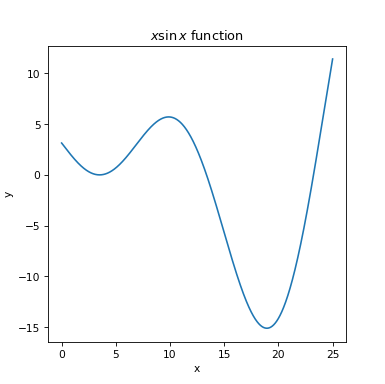

In [3]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

plt.ion()


def fun_1d(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))


X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun_1d(X_plot)


lines = []
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
lines.append(true_fun)
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# dimension of the problem
ndim = 1

Here, the training data are the points of the design of experiments=[0,7,25]. 


In [4]:
xdoe = np.atleast_2d([0, 7, 25]).T
ydoe = fun_1d(xdoe)
n_doe = xdoe.shape[0]
print("Number of DOE points = ", n_doe)

Number of DOE points =  3


Build the GP model with a square exponential kernel with SMT toolbox knowing $(x_{data}, y_{data})$.

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1259775


<IPython.core.display.Javascript object>


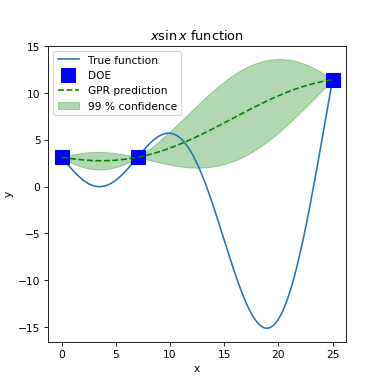

In [5]:
from smt.surrogate_models import KRG

########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2] * ndim, print_prediction=False, corr="squar_exp")

# Training
t.set_training_values(xdoe, ydoe)
t.train()


# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, doe, gp, un_gp]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "DOE", "GPR prediction", "99 % confidence"])
plt.show()


Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize this function by using Bayesian Optimization and comparing
- Surrogate Based optimization (SBO)
- Expected Improvement criterion (EI)


In a first step we compute the EI criterion

<IPython.core.display.Javascript object>


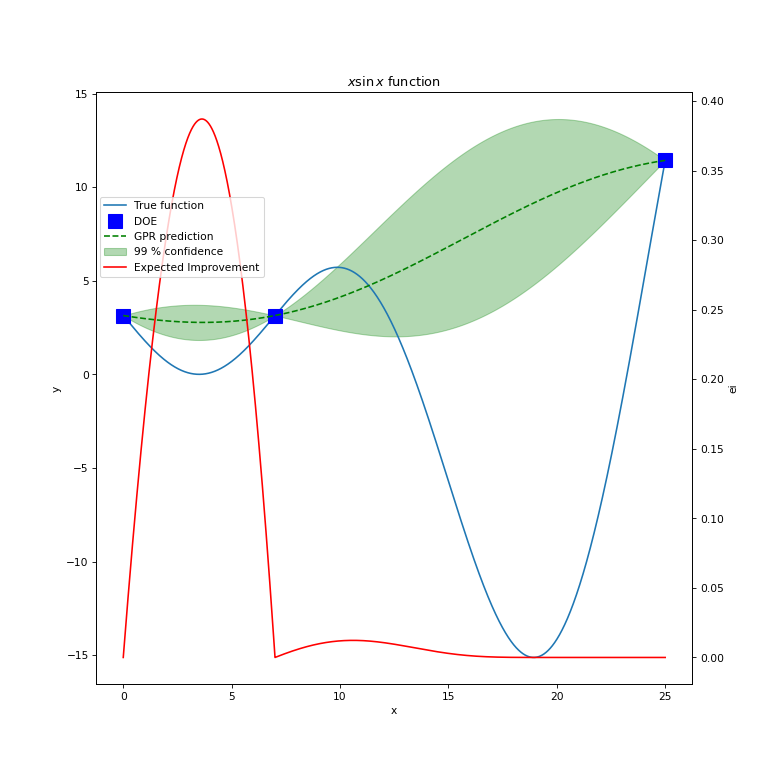

In [6]:
from scipy.stats import norm
from scipy.optimize import minimize


def EI(GP, points, f_min):
    pred = GP.predict_values(points)
    var = GP.predict_variances(points)
    args0 = (f_min - pred) / np.sqrt(var)
    args1 = (f_min - pred) * norm.cdf(args0)
    args2 = np.sqrt(var) * norm.pdf(args0)

    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0

    ei = args1 + args2
    return ei


Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
Y_EI_plot = EI(t, X_plot, np.min(ydoe))

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
ax1 = ax.twinx()
(ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
lines = [true_fun, doe, gp, un_gp, ei]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax1.set_ylabel("ei")
fig.legend(
    lines,
    [
        "True function",
        "DOE",
        "GPR prediction",
        "99 % confidence",
        "Expected Improvement",
    ],
    loc=[0.13, 0.64],
)
plt.show()

Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- LCB (Lower Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
- EI for expected Improvement (EGO)

In [7]:
# surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP, point):
    res = GP.predict_values(point)
    return res


# lower confidence bound optimization: minimize by using mu - 3*sigma
def LCB(GP, point):
    pred = GP.predict_values(point)
    var = GP.predict_variances(point)
    res = pred - 3.0 * np.sqrt(var)
    return res

In [8]:
IC = "EI"

In [9]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML


plt.ioff()


n_iter = 15

gpr = KRG(theta0=[1e-2] * ndim, print_global=False)

# initialization
x_data = xdoe
y_data = ydoe

for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20) * 25).T
    f_min_k = np.min(y_data)
    gpr.set_training_values(xdoe, ydoe)
    gpr.train()
    if IC == "EI":

        def obj_k(x):
            return -EI(gpr, np.atleast_2d(x), f_min_k)
    elif IC == "SBO":

        def obj_k(x):
            return SBO(gpr, np.atleast_2d(x))
    elif IC == "LCB":

        def obj_k(x):
            return LCB(gpr, np.atleast_2d(x))

    opt_all = np.array(
        [
            minimize(lambda x: float(obj_k(x)), x_st, method="SLSQP", bounds=[(0, 25)])
            for x_st in x_start
        ]
    )
    opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
    obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt["x"]

    y_et_k = fun_1d(x_et_k)

    y_data = np.atleast_2d(np.append(y_data, y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data, x_et_k)).T

    Y_GP_plot = gpr.predict_values(X_plot)
    Y_GP_plot_var = gpr.predict_variances(X_plot)
    Y_EI_plot = -EI(gpr, X_plot, f_min_k)

    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)
    if IC == "LCB" or IC == "SBO":
        (ei,) = ax.plot(X_plot, Y_EI_plot, color="red")
    else:
        ax1 = ax.twinx()
        (ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
    (true_fun,) = ax.plot(X_plot, Y_plot)
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(
        x_data[0 : k + n_doe],
        y_data[0 : k + n_doe],
        linestyle="",
        marker="o",
        color="orange",
    )
    (opt,) = ax.plot(
        x_data[k + n_doe], y_data[k + n_doe], linestyle="", marker="*", color="r"
    )
    (gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
    sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
    sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, doe, data, gp, un_gp, opt, ei]
    ax.set_title(r"$x \sin{x}$ function")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(
        lines,
        [
            "True function",
            "initial DOE",
            "Data",
            "GPR prediction",
            "99 % confidence",
            "Next point to Evaluate",
            "Infill Criteria",
        ],
    )
    plt.savefig("Optimisation %d" % k)
    plt.close(fig)

ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print("Results : X = %s, Y = %s" % (x_opt, y_opt))

fig = plt.figure(figsize=[10, 10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread("Optimisation %d.png" % k)
    im = plt.imshow(image_pt)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500)
HTML(ani.to_jshtml())


# Check the optimal point is x_opt=18.9, y_opt =-15.1

Results : X = [17.01266853], Y = [-12.38642307]


 ## Use the EGO from SMT 

In [11]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS
from smt.design_space import (
    DesignSpace,
    IntegerVariable,
)

* Choose your criterion to perform the optimization: EI, SBO or LCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

Minimum in x=18.9 with f(x)=-15.1


<IPython.core.display.Javascript object>


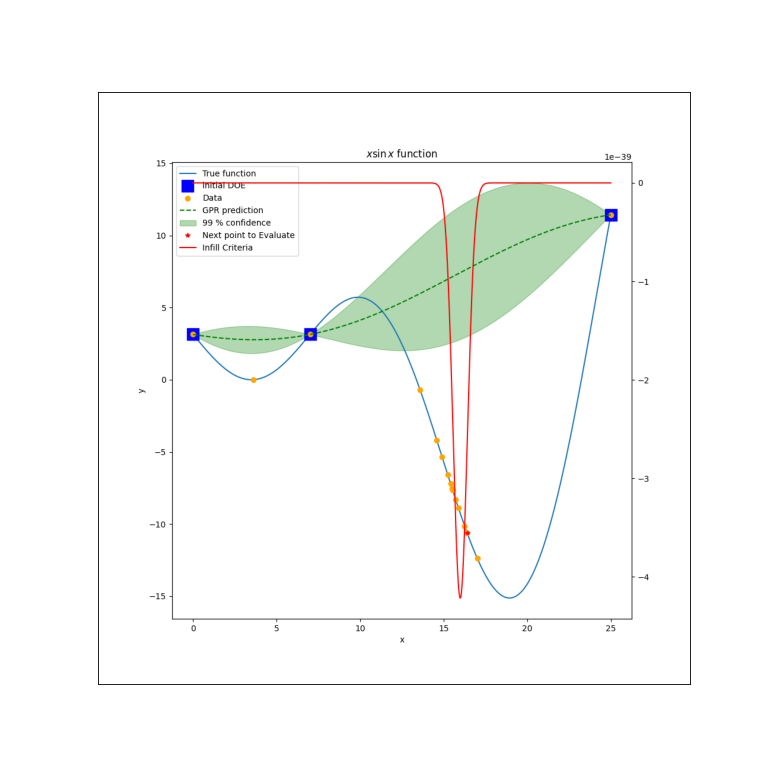

<IPython.core.display.Javascript object>


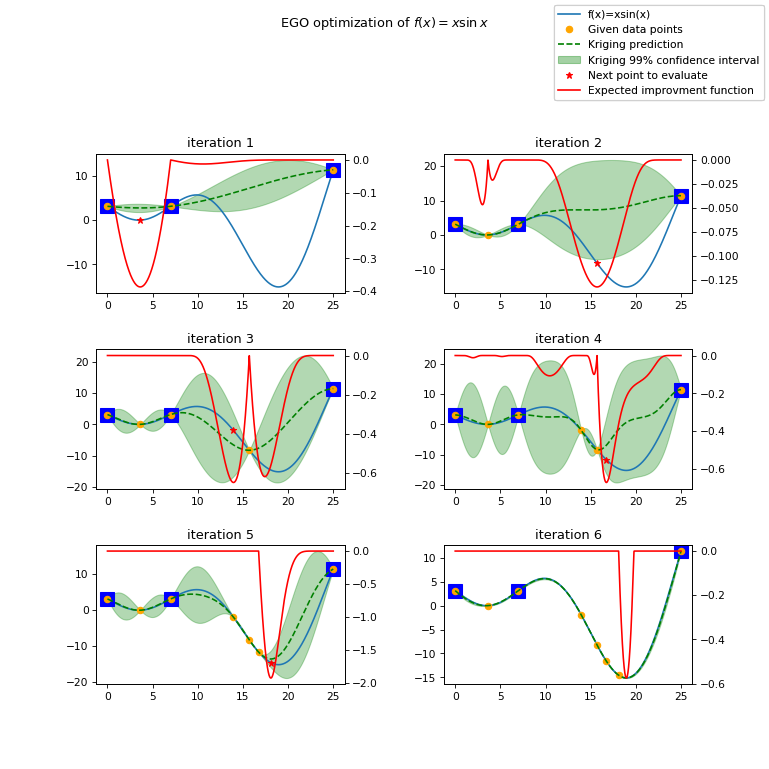

In [12]:
n_iter = 6
xlimits = np.array([[0.0, 25.0]])

random_state = 42  # for reproducibility
design_space = DesignSpace(xlimits, random_state=random_state)


criterion = "EI"  #'EI' or 'SBO' or 'LCB'

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
    random_state=random_state,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun_1d)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(x_opt.item(), y_opt.item()))


fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(X_plot)
    y_gp_plot_var = ego.gpr.predict_variances(X_plot)
    y_ei_plot = -ego.EI(X_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(X_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(X_plot, Y_plot)
    # (doe,) = ax.plot(
    # xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue"
    # )
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    if i < n_iter - 1:
        (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(X_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \\sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()
# Check the optimal point is x_opt=18.9, y_opt =-15.1

## Try with a 2D function : 2D Rosenbrock function 

Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$

In [13]:
# define the rosenbrock function
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n, dim = x.shape

    # parameters:
    Opt = []
    Opt_point_scalar = 1
    # construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    # Construction of Z vector
    Z = np.zeros((n, dim))
    for i in range(0, dim):
        Z[:, i] = x[:, i] - Opt[i] + 1

    # Sum
    sum1 = np.zeros((n, 1))
    for i in range(0, dim - 1):
        sum1[:, 0] += 100 * (((Z[:, i] ** 2) - Z[:, i + 1]) ** 2) + ((Z[:, i] - 1) ** 2)

    return sum1


xlimits = np.array([[-2, 2], [-2, 2]])

<IPython.core.display.Javascript object>


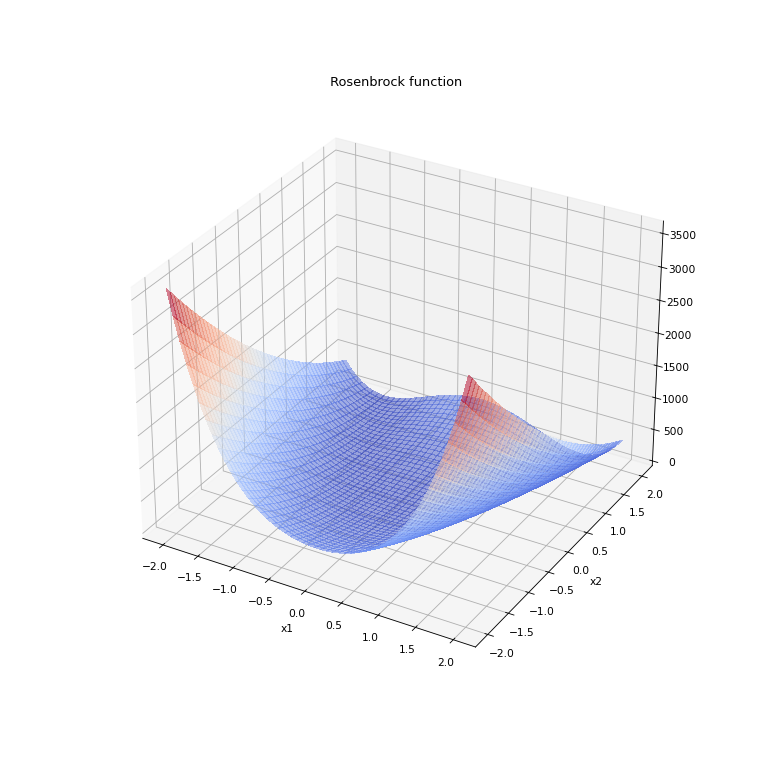

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm

# To plot the Rosenbrock function
num_plot = 50  # to plot rosenbrock
x = np.linspace(xlimits[0][0], xlimits[0][1], num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0, x1]])))
res = np.array(res)
res = res.reshape((50, 50)).T
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(
    X, Y, res, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5
)
plt.title(" Rosenbrock function")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [15]:
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

# number of points in the initial DOE
ndoe = 10  # (at least ndim+1)

# number of iterations with EGO
n_iter = 30

design_space = DesignSpace(xlimits)

# Build the initial DOE, add the random_state option to have the reproducibility of the LHS points
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)


# EGO call
sm = KRG(design_space=design_space, n_start=25, print_global=False)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=30,  # to do multistart for maximizing the acquisition function
)


x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print(
    "Xopt for Rosenbrock ", x_opt, y_opt, " obtained using EGO criterion = ", criterion
)
print("Check if the optimal point is Xopt= (1,1) with the Y value=0")
print(
    "if not you can increase the number of iterations with n_iter but the CPU will increase also."
)
print("---------------------------")

Xopt for Rosenbrock  [1.12933295 1.25449452] [0.06040129]  obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
if not you can increase the number of iterations with n_iter but the CPU will increase also.
---------------------------


<IPython.core.display.Javascript object>


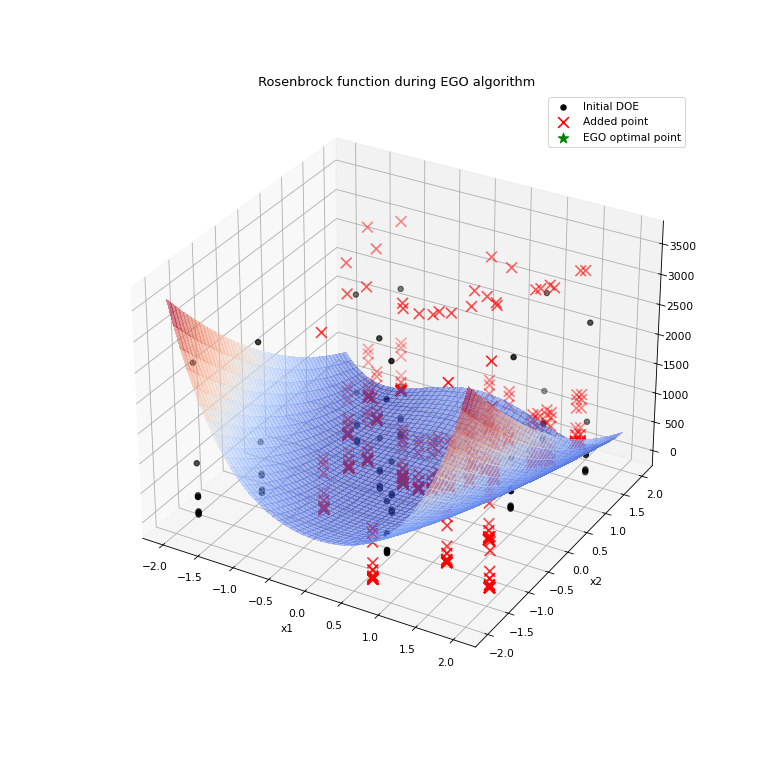

<IPython.core.display.Javascript object>


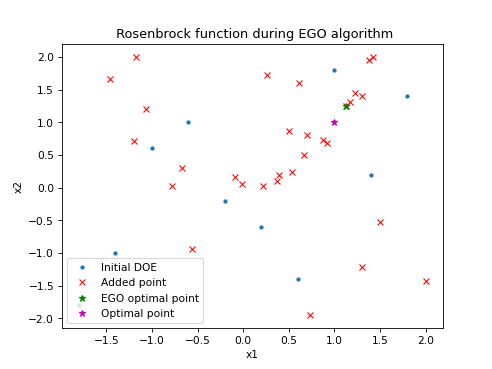

In [16]:
# To plot the Rosenbrock function
# 3D plot
x = np.linspace(xlimits[0][0], xlimits[0][1], num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0, x1]])))
res = np.array(res)
res = res.reshape((50, 50)).T
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

surf = ax.plot_surface(
    X, Y, res, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5
)
# to add the points provided by EGO
ax.scatter(
    x_data[:ndoe, 0],
    x_data[:ndoe, 1],
    y_data[:ndoe],
    zdir="z",
    marker=".",
    c="k",
    s=100,
    label="Initial DOE",
)
ax.scatter(
    x_data[ndoe:, 0],
    x_data[ndoe:, 1],
    y_data[ndoe:],
    zdir="z",
    marker="x",
    c="r",
    s=100,
    label="Added point",
)
ax.scatter(
    x_opt[0],
    x_opt[1],
    y_opt,
    zdir="z",
    marker="*",
    c="g",
    s=100,
    label="EGO optimal point",
)

plt.title(" Rosenbrock function during EGO algorithm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


# 2D plot
# to add the points provided by EGO
plt.plot(x_data[:ndoe, 0], x_data[:ndoe, 1], ".", label="Initial DOE")
plt.plot(x_data[ndoe:, 0], x_data[ndoe:, 1], "x", c="r", label="Added point")
plt.plot(x_opt[:1], x_opt[1:], "*", c="g", label="EGO optimal point")
plt.plot([1], [1], "*", c="m", label="Optimal point")

plt.title(" Rosenbrock function during EGO algorithm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

We can now compare the results by using only the mean information provided by surrogate model approximation


In [17]:
criterion = "SBO"  #'EI' or 'SBO' or 'LCB'

# number of iterations with EGO
n_iter = 30


# EGO call with the same initial DOE as before
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=30,  # to do multistart for maximizing the acquisition function
)


x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print(
    "Xopt for Rosenbrock ", x_opt, y_opt, " obtained using EGO criterion = ", criterion
)
print("Check if the optimal point is Xopt=(1,1) with the Y value=0")
print("---------------------------")

Xopt for Rosenbrock  [0.89836098 0.80833958] [0.01049616]  obtained using EGO criterion =  SBO
Check if the optimal point is Xopt=(1,1) with the Y value=0
---------------------------


## EGO and tunneling penalization

The main idea of tunneling  is to penalize the acquisition function in the neighbourhood of already evaluated points. The associated reference is given by:

Zhang, S., & Norato, J. A. (2018, August). Finding better local optima in topology optimization via tunneling. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 51760, p. V02BT03A014). American Society of Mechanical Engineers.


In [18]:
from smt.applications.mixed_integer import MixedIntegerSamplingMethod
from smt.sampling_methods import FullFactorial

Definition of the plot function for 1D

In [19]:
def PlotEgo(criterion, Xsol, Ysol, xdoe, bounds, npt, n_iter, tunneling, sm):
    ego = EGO(
        n_iter=n_iter,
        criterion=criterion,
        xdoe=xdoe,
        n_start=20,
        n_max_optim=35,
        enable_tunneling=tunneling,
        surrogate=sm,
    )
    x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=fun)
    print("Minimum in x={:.0f} with fun(x)={:.10f}".format(int(x_opt), float(y_opt)))

    x_plot = np.atleast_2d(np.linspace(bounds[0][0], bounds[0][1], 9 * (npt - 1) + 1)).T
    fig = plt.figure(figsize=[15, 15])
    n_doe = xdoe.size
    for i in range(n_iter):
        k = n_doe + i
        x_data_k = x_data[0:k]
        y_data_k = y_data[0:k]

        # if check list, not already evaluated
        y_data[k] = fun(x_data[k][:, np.newaxis])
        ego.gpr.set_training_values(x_data_k, y_data_k)
        ego.gpr.train()
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)
        y_ei_plot = ego.EI(x_plot, False)
        ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
        ax1 = ax.twinx()
        (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

        true_fun = ax.scatter(Xsol, Ysol, color="k", marker="d")
        (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
        if i < n_iter - 1:
            (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
            print(x_data[k], y_data[k])
        (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
        sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei]
        fig.suptitle("EGO optimization of a set of points")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}".format(i + 1))
        fig.legend(
            lines,
            [
                "set of points",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
            ],
        )
    plt.show()

### Tunneling for 1D function 

In [20]:
def fun(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))


bounds = np.array([[0, 25]])
xlimits = bounds
design_space = DesignSpace(
    [
        IntegerVariable(bounds[0][0], bounds[0][1]),  # to have integer variable
    ]
)

<IPython.core.display.Javascript object>


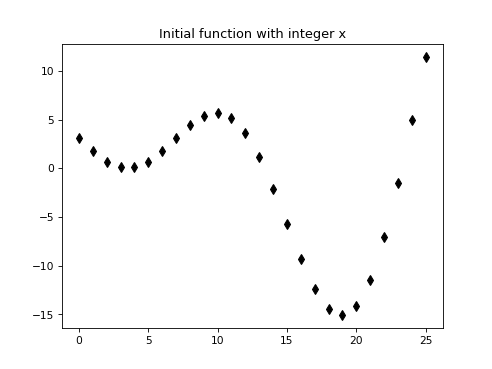

In [21]:
X_plot = np.atleast_2d(np.arange(xlimits[0][0], xlimits[0][1] + 1, 1))
Y_plot = fun(X_plot)
npts = np.shape(X_plot)[1]
plt.plot(X_plot, Y_plot, "kd")
plt.title("Initial function with integer x")
plt.show()

In [22]:
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

sm = KRG(design_space=design_space, print_global=False)
sampling = MixedIntegerSamplingMethod(FullFactorial, design_space)

xdoe = sampling(4)
n_iter = 3
ego = EGO(
    xdoe=xdoe,
    n_iter=n_iter,
    criterion=criterion,
    surrogate=sm,
    enable_tunneling=True,  # to impose tunneling
    random_state=42,
    n_start=30,
)

x_opt, y_opt, _, _, _ = ego.optimize(fun=fun)

In [23]:
print(
    "Xopt for xsinx function, ",
    x_opt,
    y_opt,
    " obtained using EGO criterion = ",
    criterion,
)
print("Check if the optimal point is 19 associated to y=-15.12")
print("---------------------------")

Xopt for xsinx function,  [19.] [-15.12161154]  obtained using EGO criterion =  EI
Check if the optimal point is 19 associated to y=-15.12
---------------------------


<IPython.core.display.Javascript object>


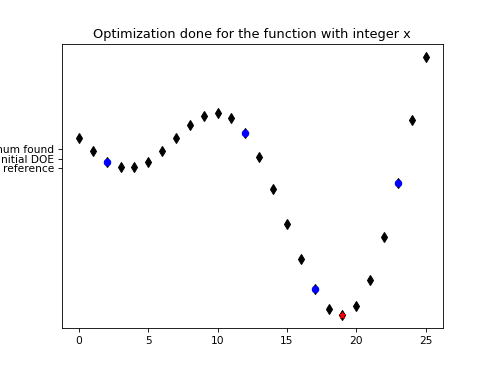

In [24]:
plt.plot(X_plot, Y_plot, "kd", "reference")
plt.plot(xdoe, fun(xdoe), "bo", "initial DOE")
plt.plot(x_opt, y_opt, "r*", "Optimum found")
plt.title("Optimization done for the function with integer x")
plt.show()

Minimum in x=19 with fun(x)=-15.1216115361
[19.] [-15.12161154]
[6.] [1.78601478]
[0.] [3.14127616]
[25.] [11.42919546]


<IPython.core.display.Javascript object>


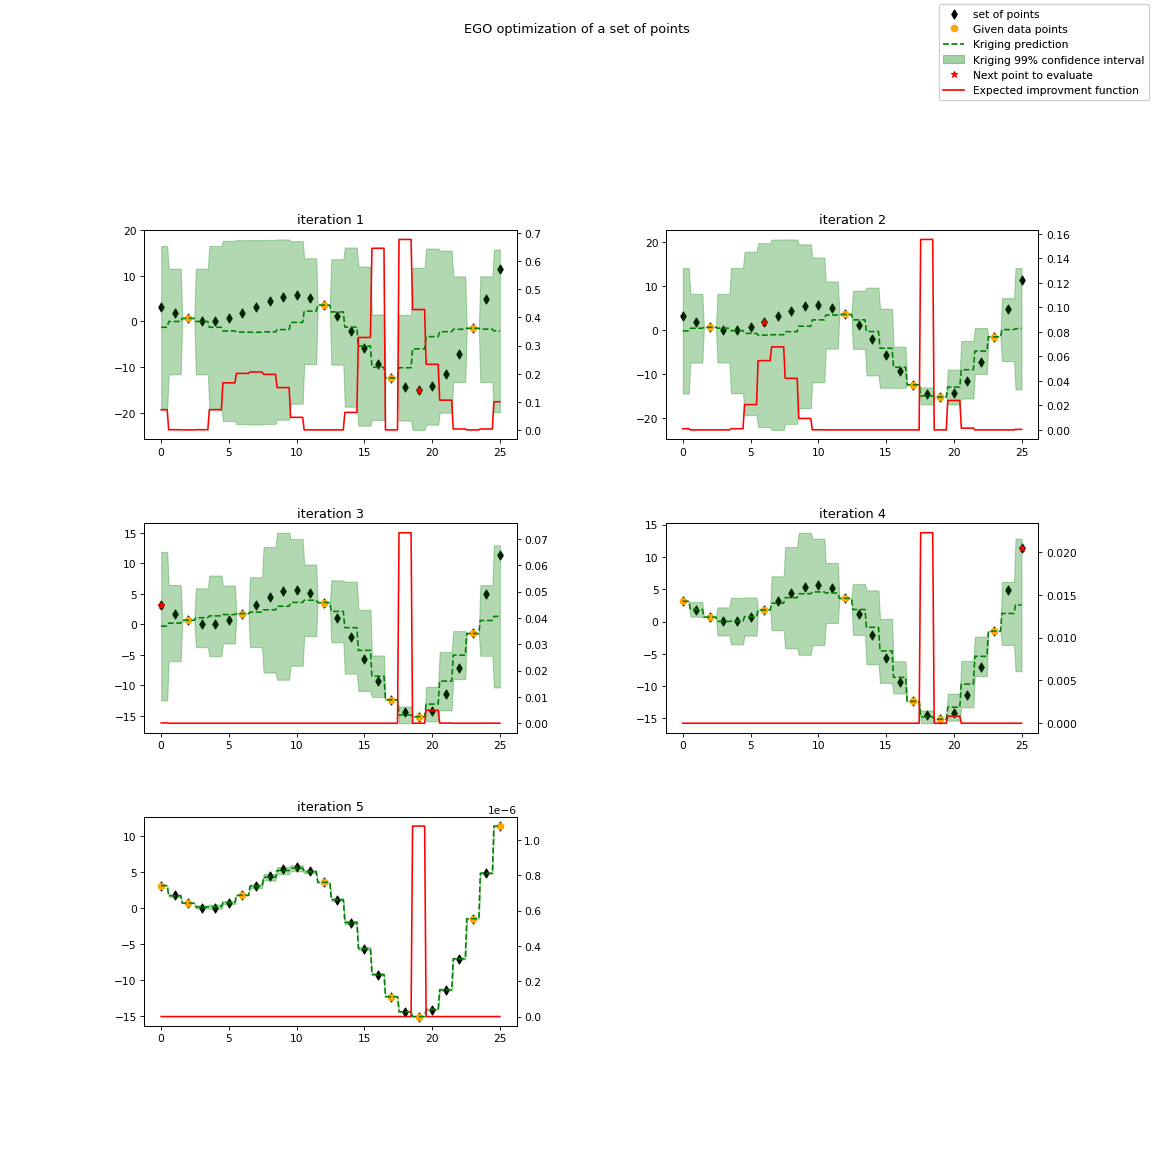

In [25]:
# To have a nice plot with the different iterations
tunneling = True
n_iter = 5

PlotEgo(criterion, X_plot, Y_plot, xdoe, bounds, npts, n_iter, tunneling, sm)

## qEI example to add several interesting points 

Minimum in x=19.0 with f(x)=-15.1


<IPython.core.display.Javascript object>


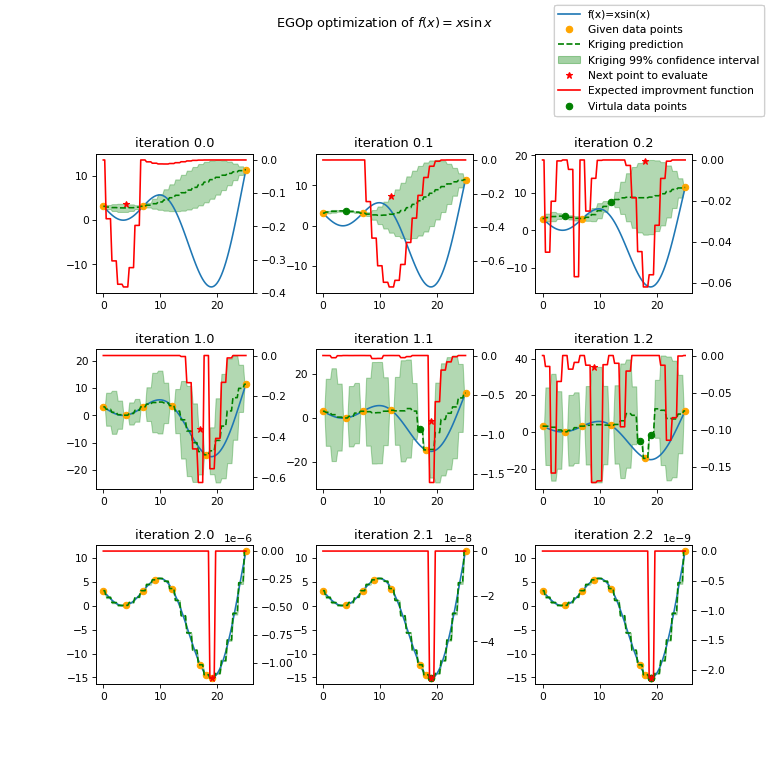

In [26]:
from smt.applications.ego import Evaluator

n_iter = 3
n_parallel = 3
n_start = 50
xlimits = np.array([[0.0, 25.0]])
xdoe = np.atleast_2d([0, 7, 25]).T
n_doe = xdoe.size


class ParallelEvaluator(Evaluator):
    """
    Implement Evaluator interface using multiprocessing ThreadPool object (Python 3 only).
    """

    def run(self, fun, x):
        n_thread = 5
        # Caveat: import are made here due to SMT documentation building process
        import numpy as np
        from sys import version_info
        from multiprocessing.pool import ThreadPool

        if version_info.major == 2:
            return fun(x)
        # Python 3 only
        with ThreadPool(n_thread) as p:
            return np.array(
                [y[0] for y in p.map(fun, [np.atleast_2d(x[i]) for i in range(len(x))])]
            )


criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KBUB"  # "KB", "KBLB", "KBUB", "KBRand"
ego = EGO(
    xdoe=xdoe,
    n_iter=n_iter,
    criterion=criterion,
    surrogate=sm,
    n_parallel=n_parallel,
    qEI=qEI,
    n_start=n_start,
    evaluator=ParallelEvaluator(),
    random_state=42,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_opt), float(y_opt)))

x_plot = np.atleast_2d(np.linspace(0, 25, 100)).T
y_plot = fun(x_plot)

fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + (i) * (n_parallel)
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    x_data_sub = x_data_k.copy()
    y_data_sub = y_data_k.copy()
    for p in range(n_parallel):
        ego.gpr.set_training_values(x_data_sub, y_data_sub)
        ego.gpr.train()

        y_ei_plot = -ego.EI(x_plot)
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)

        x_data_sub = np.append(x_data_sub, x_data[k + p])
        y_KB = ego._get_virtual_point(np.atleast_2d(x_data[k + p]), y_data_sub)

        y_data_sub = np.append(y_data_sub, y_KB)

        ax = fig.add_subplot(n_iter, n_parallel, i * (n_parallel) + p + 1)
        ax1 = ax.twinx()
        (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

        (true_fun,) = ax.plot(x_plot, y_plot)
        (data,) = ax.plot(
            x_data_sub[: -1 - p],
            y_data_sub[: -1 - p],
            linestyle="",
            marker="o",
            color="orange",
        )
        (virt_data,) = ax.plot(
            x_data_sub[-p - 1 : -1],
            y_data_sub[-p - 1 : -1],
            linestyle="",
            marker="o",
            color="g",
        )

        (opt,) = ax.plot(
            x_data_sub[-1], y_data_sub[-1], linestyle="", marker="*", color="r"
        )
        (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
        sig_plus = y_gp_plot + 3.0 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3.0 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei, virt_data]
        fig.suptitle(r"EGOp optimization of $f(x) = x \sin{x}$")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}.{}".format(i, p))
        fig.legend(
            lines,
            [
                "f(x)=xsin(x)",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
                "Virtula data points",
            ],
        )
plt.show()

<div class="alert alert-warning" >
If you use hierarchical variables and the size of your doe greater than 30 points, you may leverage the `numba` JIT compiler to speed up the computation
To do so:
    
 - install numba library
    
     `pip install numba`
    
    
 - and define the environment variable `USE_NUMBA_JIT = 1` (unset or 0 if you do not want to use numba) 
    
     - Linux: export USE_NUMBA_JIT = 1
    
     - Windows: set USE_NUMBA_JIT = 1

</div>

# EXAMPLE: CONSTRAINED EXPECTED IMPROVEMENT (cEI)
An example of a constrained optimization problem is shown, where the problem is solved using constrained Expected Imrovement (cEI). SMT is used for creating the initial sampling using Latin Hypercube Sampling (LHS). A typical constrained optimization problem can mathematically be formulated as:
$$
\begin{align}
\textbf{x}^* = \underset{\textbf{x} \in \textbf{X}}{\text{arg min}} &\; f(\textbf{x}) \\
\mathrm{s.t}\quad& g_i(\textbf{x}) \leq \lambda_i, \quad i = 1, 2,...,I
\end{align}
$$
Where $\textbf{x}$ is a d-dimensional vector of design variables, and the design space $\textbf{X}$ is a bounded subset of $\mathbb{R}^d$. $f: \textbf{X} \rightarrow \mathbb{R}$ is the objective function, subjected to $I$ number of inequality constraints expressed by the $i^{th}$ constraint function as $g_i: \textbf{X} \rightarrow \mathbb{R}$. The goal is to find the value of $\textbf{x}$ that minimizes the evaluation of the objective function $f(\textbf{x})$, and also fulfills the constraint evaluations, $g_i(\textbf{x}) \leq \lambda_i$. This optimum combination of design variables is denoted $\textbf{x}^*$.

In this example, the objective function $f(\textbf{x})$ is the 2D Branin function, and the constraint $g(\textbf{x})$ is a Sphere function, which is to be less than or equal to 40, i.e. $\lambda = 40$. The example can easily be expanded to include multiple constraints.



The following implements a penalization technique by Probability of Feasibility (PoF).


## Creating the sampling set using Latin Hypercube Sampling

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from smt.problems import Branin, Sphere
from smt.sampling_methods import LHS

ndim = 2
goal = Branin(ndim=ndim)
constraint = Sphere(ndim=ndim)

x0_lim = [-5, 10]
x1_lim = [0, 15]

xlimits = np.array([x0_lim, x1_lim])
sampling = LHS(
    xlimits=xlimits, random_state=12
)  # Random state is the seed number, only used for reproducibility
num = 15
x_t = sampling(num)

y_t = goal(x_t)
g_t = constraint(x_t)

## Training surrogates for the objective and constraint functions

In [28]:
from smt.surrogate_models import KRG

# Training the surrogate for the objective function
y_hat = KRG(theta0=[1e-2])
y_hat.set_training_values(x_t, y_t)
y_hat.train()

# Training the surrogate for the constraint function
g_hat = KRG(theta0=[1e-2])
g_hat.set_training_values(x_t, g_t)
g_hat.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 15
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.4364576
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 15
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.6388738


In [29]:
# Create plotting data
num = 500
x = np.zeros([num, 2])
x[:, 0] = np.linspace(-5.0, 10.0, num)
x[:, 1] = np.linspace(0.0, 15.0, num)

X, Y = np.meshgrid(x[:, 0], x[:, 1])  # Create a grid
f = np.zeros([num, num])
g = np.zeros([num, num])
for i in range(num):
    f[:, i] = y_hat.predict_values(np.array([X[:, i], Y[:, i]]).T).flatten()
    g[:, i] = g_hat.predict_values(np.array([X[:, i], Y[:, i]]).T).flatten()

from IPython.display import clear_output

clear_output()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Ploting objective function
contour1 = axes[0].contourf(
    X, Y, f, levels=40, cmap="RdBu_r"
)  # Filled contours in red and blue
contour_lines = axes[0].contour(
    X, Y, f, levels=40, colors="black"
)  # Contour lines in black
fig.colorbar(contour1, ax=axes[0])
axes[0].scatter(x_t[:, 0], x_t[:, 1], color="black")
axes[0].set_title("Predicted object function", fontsize=16)
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

# Ploting constraint function
contour2 = axes[1].contourf(
    X, Y, g, levels=40, cmap="RdBu_r"
)  # Filled contours in red and blue
contour_lines = axes[1].contour(
    X, Y, g, levels=40, colors="black"
)  # Contour lines in black
fig.colorbar(contour2, ax=axes[1])
axes[1].scatter(x_t[:, 0], x_t[:, 1], color="black")
axes[1].set_title("Predicted constraint function", fontsize=16)
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

Text(0, 0.5, 'x2')

## Calculating the expected improvement

The constrained expected improvement $\text{cEI}(\textbf{x})$ is calculated as: $$\text{cEI}(\textbf{x}) = \text{EI}(\textbf{x})\text{PoF}(\textbf{x})$$
Here the Expected Improvement $\text{EI}(\textbf{x})$ is calculated as; 
$$\text{EI}(\textbf{x}) = (\text{y}^* - \hat{\mu}_y(\textbf{x}))\Phi\left(\frac{\text{y}^* - \hat{\mu}_y(\textbf{x})}{\hat{\sigma}_y(\textbf{x})}\right)+\hat{\sigma}_y(\textbf{x})\phi\left(\frac{\text{y}^* - \hat{\mu}_y(\textbf{x})}{\hat{\sigma}_y(\textbf{x})}\right)$$
Where $\text{y}^*$ is the current best sampled value of the objective function that satisfies the constraints, $\Phi$ and $\phi$ are respectively the cumulative and probability density function of a standardized normal distribution, $\hat{\mu}_y$ and $\hat{\sigma}_y$ are respectively the predictive mean and variance of the objective function. The Probability of Feasability $\text{PoF}(\textbf{x})$ is calculated as;
$$\text{PoF}(\textbf{x}) = \prod_{i = 1}^{n_c}P(\hat{g}_i(\textbf{x}) \leq \lambda_i) = \prod_{i = 1}^{n_c}\Phi\left(\frac{\lambda_i - \hat{\mu}_{gi}(\textbf{x})}{\hat{\sigma}_{gi}(\textbf{x})}\right)$$
Where $\lambda_i$ is the upper bound of constraint $g_i$, $\hat{\mu}_{gi}$ and $\hat{\sigma}_{gi}$ are respectively the predictive mean and variance of constraint $g_i$.

In [30]:
lambda_i = 40
y_min = np.min(y_t[np.where(g_t <= lambda_i)[0]])


def ExpectedImprovement(x, objective, y_min):
    from scipy.special import erf

    mu = objective.predict_values(x)
    var = objective.predict_variances(x) + 1e-6
    EI = (y_min - mu) * (0.5 + 0.5 * erf((y_min - mu) / np.sqrt(var * 2))) + np.sqrt(
        var / (2 * np.pi)
    ) * np.exp(-pow(y_min - mu, 2) / (2 * var))
    return EI


def ProbabilityOfFeasibility(x, constraint, lambda_i):
    from scipy.special import erf

    mu = constraint.predict_values(x)
    var = constraint.predict_variances(x) + 1e-6
    PF = 0.5 + 0.5 * erf((lambda_i - mu) / np.sqrt(var * 2))
    return PF

## Finding the optimal variabel combination $\textbf{x}^*$
The purpose is to find the optimal variabel combination $\textbf{x}^*$, which can be found by maximizing the aquisition function $\text{cEI(\textbf{x})}$:
$$ \textbf{x}^* = \underset{\textbf{x} \in \textbf{X}}{\text{arg max }} \text{cEI}(\textbf{x})$$
For the maximization purpose Evolutionary Strategy of the  python package Pymoo is used.

In [31]:
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.optimize import minimize


def cEI_problem(x):
    return ExpectedImprovement(x, y_hat, y_min) * ProbabilityOfFeasibility(
        x, g_hat, lambda_i
    )


import numpy as np
from pymoo.core.problem import Problem


class MyProblem(Problem):
    def __init__(self, object, constraint, y_min, lambda_i):
        self.object = object
        self.constraint = constraint
        self.y_min = y_min
        self.lambda_i = lambda_i
        super().__init__(n_var=2, n_obj=1, xl=np.array([-5, 0]), xu=np.array([10, 15]))

    def _evaluate(self, x, out, *args, **kwargs):
        cEI = ExpectedImprovement(
            x, self.object, self.y_min
        ) * ProbabilityOfFeasibility(x, self.constraint, self.lambda_i)
        out["F"] = -cEI


problem = MyProblem(y_hat, g_hat, y_min, lambda_i)
algorithm = ES(n_offsprings=200, rule=1.0 / 7.0)

res = minimize(problem, algorithm, ("n_gen", 200), seed=1, verbose=False)

clear_output()
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [2.62797087 3.156598  ]
F = [-21.43088929]


### Creating plots to illustrate the components of cEI ($\textbf{x}^*$ is shown as yellow star)

In [32]:
# Create plotting data
EI_M = np.zeros([num, num])
PF_M = np.zeros([num, num])
cEI_M = np.zeros([num, num])
for i in range(num):
    EI = ExpectedImprovement(np.array([X[:, i], Y[:, i]]).T, y_hat, y_min)
    PF = ProbabilityOfFeasibility(np.array([X[:, i], Y[:, i]]).T, g_hat, lambda_i)
    EI_M[:, i] = (
        EI.flatten() + 1e-12
    )  # The 1e-12 is only added to ensure a pretty plot and does not affect the result
    PF_M[:, i] = PF.flatten()
    cEI_M[:, i] = (
        (EI * PF).flatten() + 1e-12
    )  # The 1e-12 is only added to ensure a pretty plot and does not affect the result

from IPython.display import clear_output

n_levels = 20
clear_output()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Ploting objective function
contour1 = axes[0].contourf(
    X, Y, EI_M, levels=n_levels, cmap="RdBu_r"
)  # Filled contours in red and blue
contour_lines = axes[0].contour(
    X, Y, EI_M, levels=n_levels, colors="black"
)  # Contour lines in black
fig.colorbar(contour1, ax=axes[0])
axes[0].set_title("Expected Improvement", fontsize=16)
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

# Ploting constraint function
contour2 = axes[1].contourf(
    X, Y, PF_M, levels=n_levels, cmap="RdBu_r"
)  # Filled contours in red and blue
contour_lines = axes[1].contour(
    X, Y, PF_M, levels=n_levels, colors="black"
)  # Contour lines in black
fig.colorbar(contour2, ax=axes[1])
axes[1].set_title("Probability of Feasibility", fontsize=16)
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

fig, axes = plt.subplots(figsize=(6, 4))
# Ploting objective function
contour1 = axes.contourf(
    X, Y, cEI_M, levels=n_levels, cmap="RdBu_r"
)  # Filled contours in red and blue
contour_lines = axes.contour(
    X, Y, cEI_M, levels=n_levels, colors="black"
)  # Contour lines in black
axes.scatter([res.X[0]], [res.X[1]], marker="*", color="yellow", s=50)
fig.colorbar(contour1, ax=axes)
axes.set_title("constrained Expected Improvement", fontsize=16)
axes.set_xlabel("x1")
axes.set_ylabel("x2")

Text(0, 0.5, 'x2')